In [1]:
from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
import astropy.units as u
import schwimmbad
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

t, rv, err = np.loadtxt('data/bischoff_rv.txt',usecols=(0,1,2)).T
# t, rv, err = np.loadtxt('data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
# t -= t[0]
rv *= u.km/u.s
err *= u.km/u.s 

INFO: 1 good sample after rejection sampling [thejoker.sampler.sampler]


Text(0, 0.5, '$K$ [km/s]')

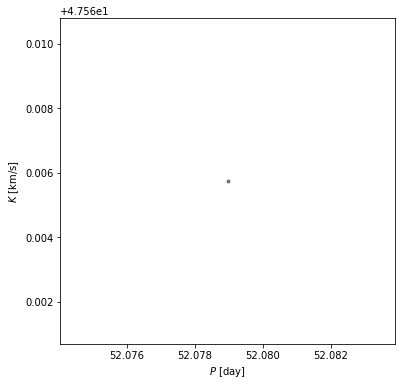

In [2]:
data = RVData(t=t, rv=rv, stddev=err)
params = JokerParams(P_min=8*u.day, P_max=100*u.day)
pool = schwimmbad.MultiPool()
joker = TheJoker(params, pool=pool)

samples = joker.rejection_sample(data, n_prior_samples=65536)

fig, ax = plt.subplots(1, 1, figsize=(6,6)) # doctest: +SKIP
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
           marker='.', color='k', alpha=0.45) # doctest: +SKIP
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")

In [3]:
samples

JokerSamples([('P', <Quantity [52.07896479] d>),
              ('M0', <Quantity [2.99763067] rad>),
              ('e', <Quantity [0.36850825]>),
              ('omega', <Quantity [0.44413882] rad>),
              ('jitter', <Quantity [0.] km / s>),
              ('K', <Quantity [47.56575686] km / s>),
              ('v0', <Quantity [-12.71306408] km / s>)])

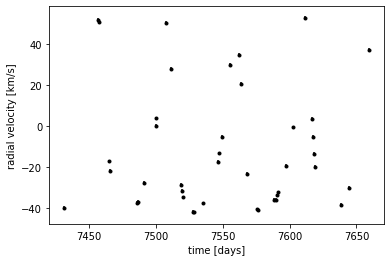

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = t
y = rv.value
# y -= np.mean(y)
yerr = err.value

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]");

In [5]:
import exoplanet as xo

period = 51.419#samples['P'].value
period_err = [0.1]
t0s = [0]
t0_errs = [0.0007]
Ks = samples['K'].value

In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    t0 = pm.Uniform('t0', lower=0.01, upper=500, testval=100)
    P = pm.Bound(pm.Normal, lower=0)("P", mu=period, sd=0.1,
                                     shape=1, testval=period)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)("logK", mu=np.log(Ks), sd=10.0,
                                        shape=1, testval=np.log(Ks))

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.1)
    omega = xo.distributions.Angle("omega", shape=1)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    t_per = pm.Deterministic('t_per', orbit.t_periastron)
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    
    # Define the background model
#     trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=1)
#     A = np.vander(x - 0.5*(x.min() + x.max()), 1)
#     bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=10)
    rv_model = pm.Deterministic("rv_model", vrad + gammav)
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

0.8275467546646788

In [21]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)

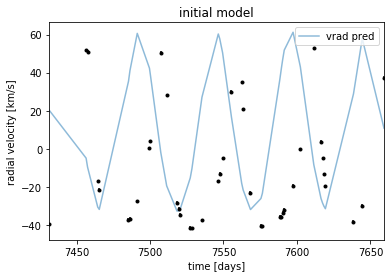

In [7]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(x, xo.eval_in_model(rv_model), alpha=0.5, label='vrad pred')
#     plt.plot(t, xo.eval_in_model(vrad_pred), alpha=0.5, label='vrad pred')
plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]")
plt.title("initial model");

In [8]:
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [gammav, logs, omega, ecc, logK, P, t0]
176it [00:01, 146.76it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -45043.96544293867 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [gammav, logs, omega, ecc, logK, P, t0]
176it [00:01, 141.26it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -45043.96544293867 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


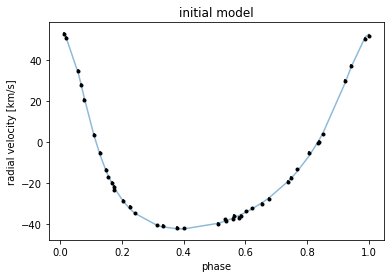

In [24]:

plt.errorbar(x % map_soln['P'] / map_soln['P'], y, yerr=yerr, fmt=".k")

with model:
    x_sort = x % map_soln['P'] / map_soln['P']
    sort = np.argsort(x_sort)
    plt.plot(x_sort[sort], xo.eval_in_model(rv_model, map_soln)[sort], alpha=0.5)
plt.xlabel("phase")
plt.ylabel("radial velocity [km/s]")
plt.title("initial model");

In [25]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=2000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.95))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammav, logs, omega, ecc, logK, P, t0]
Sampling 2 chains: 100%|██████████| 6000/6000 [02:23<00:00, 41.79draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


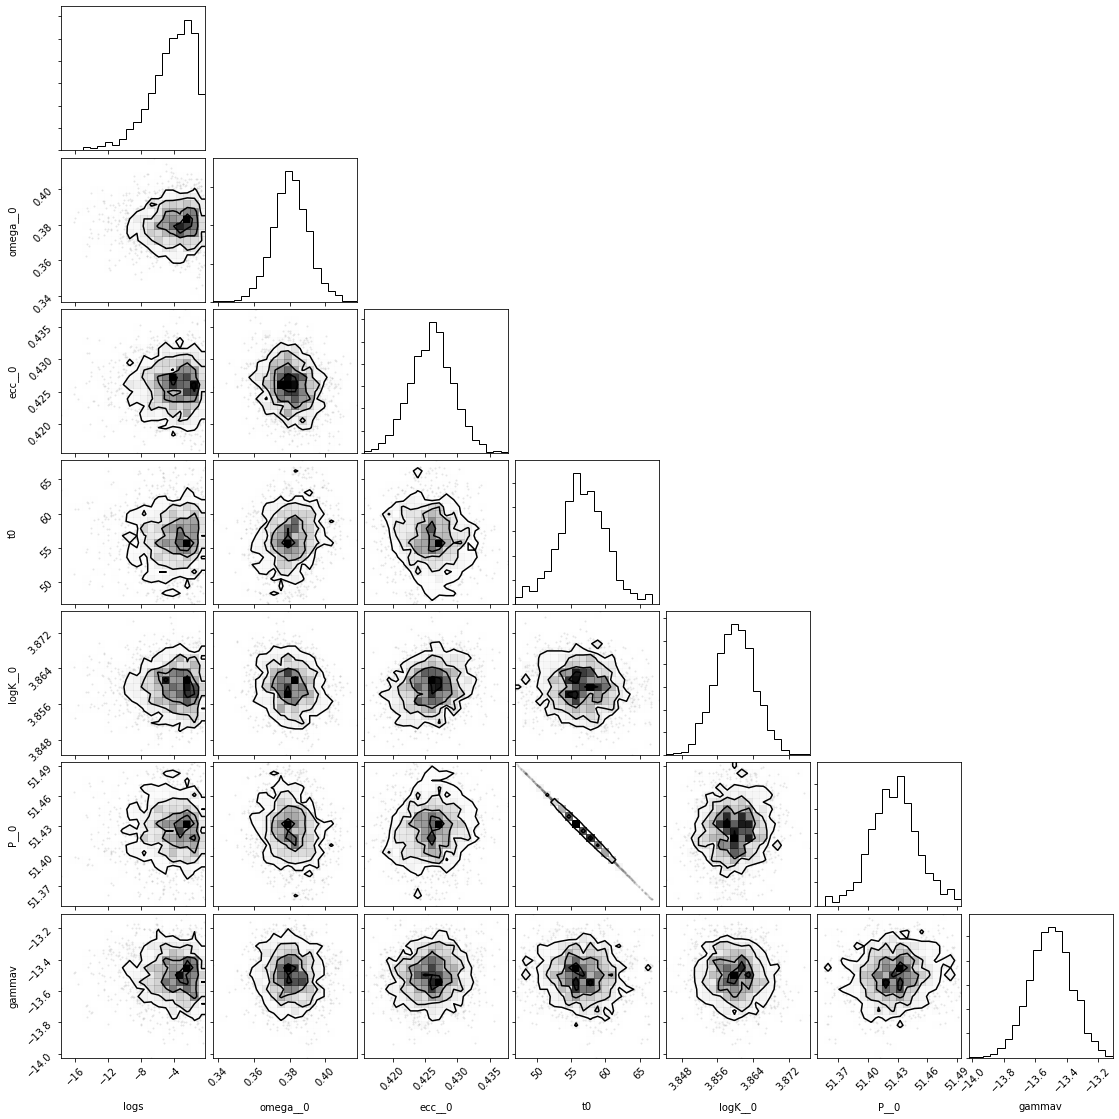

In [26]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=["logs", "omega", "ecc", "t0", "logK", "P", 'gammav']));

In [28]:
pm.save_trace(trace, 'data/traces/x')

'data/traces/x'

In [38]:
%run setup.py

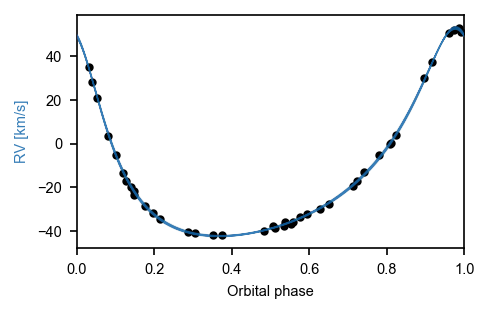

In [40]:
plt.figure(figsize=mnras_size(240.))
gv = np.mean(trace['gammav'])
with model:
    for sample in xo.get_samples_from_trace(trace, 500):
        
        tt = (t - sample['t_per']) % sample['P'] / sample['P']
        sort = np.argsort(tt)
        plt.plot(tt[sort], sample['vrad_pred'][sort] + gv, alpha=0.1, label='vrad pred', linewidth=0.1, c=blue, zorder=5)
        
plt.errorbar((x - np.median(trace['t_per'])) % np.mean(trace['P']) / np.mean(trace['P']), y, yerr=yerr, fmt=".k", zorder=1)

plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]', c=blue)
plt.xlim(0,1)

plt.savefig('figs/rv_fit.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [27]:
pm.summary(trace, varnames=["logs", "omega", "ecc", "t0", "logK", "P", 'gammav'])

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs,-4.728330,3.098434,0.115513,-11.005473,-0.307358,676.778401,0.999630
omega__0,0.378708,0.010001,0.000240,0.359643,0.397088,1717.565685,0.999500
ecc__0,0.426692,0.003286,0.000077,0.420074,0.432707,1728.085392,0.999552
t0,152.815712,3.304814,0.114776,145.923247,158.949885,732.495040,1.000991
logK__0,3.861042,0.004422,0.000107,3.852435,3.869554,1904.932301,0.999503
P__0,51.472162,0.022913,0.000797,51.429591,51.519760,731.675934,1.000979
gammav,-13.496820,0.125492,0.002938,-13.756006,-13.264662,1668.013295,0.999748


In [2]:
import numpy as np
np.exp(3.861042), np.exp(0.004422)

(47.514836042017194, 1.0044317914693057)

In [6]:
import numpy as np
import astropy.units as u

(np.exp(3.861042) * (u.km / u.s) * (51.472162 * u.day).to(u.s) * np.sqrt(1-0.426692**2) / 
     (2 * np.pi)).to(u.R_sun)# / (299792.458 * u.km / u.s)

<Quantity 43.71924266 solRad>

In [4]:
import numpy as np
43.719 / np.sin(np.radians(87))

43.77899759468311

In [5]:
np.sin(np.radians(87))

0.9986295347545738

In [6]:
V = 3.68
BC = 0.8
M_bol = 4.75
(10 * (1/82.0863) * 2.1940616334193774)**(-1/2) * 10**(-0.1 * (V + BC - M_bol)) * 5778

11892.919141107921